In [62]:
import argparse
import random

import numpy as np
import scipy.sparse as sp
import scipy.sparse.csgraph
import sklearn.linear_model as sklm
import sklearn.metrics as skm
import sklearn.model_selection as skms
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from ignite.engine import Engine, Events
from ignite.handlers import ModelCheckpoint
from torch.utils.data import DataLoader, IterableDataset, get_worker_info
import umap
from sklearn.datasets import make_swiss_roll,make_s_curve
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.utils import check_random_state
from sklearn.neighbors import kneighbors_graph,radius_neighbors_graph
from sklearn.decomposition import PCA
from sklearn import manifold

CHECKPOINT_PREFIX = "g2g"
from scipy.sparse import csr_matrix
from g2g_model_Fisher import CompleteKPartiteGraph,AttributedGraph,GraphDataset,Encoder,\
                            level_sets,train_test_split,reset_seeds

In [63]:
torch.cuda.is_available()
# torch.cuda.device_count()
# torch.cuda.current_device()

False

In [64]:
# #-------severed sphere
# n_samples=3000
# random_state = check_random_state(0)
# p = random_state.rand(n_samples) * (2 * np.pi-0.2)
# t = random_state.rand(n_samples) * np.pi

# # Sever the poles from the sphere.
# indices = (t < (np.pi - (np.pi / 4))) & (t > ((np.pi / 4)))
# # indices = ((t < np.pi) & (t > np.pi))
# colors = p[indices]
# x, y, z = (
#     np.sin(t[indices]) * np.cos(p[indices]),
#     np.sin(t[indices]) * np.sin(p[indices]),
#     np.cos(t[indices]),
# )


# fig = plt.figure(figsize=(25, 18))#


# ax = fig.add_subplot(251, projection="3d")
# ax.scatter(x, y, z, c=p[indices],s=10, cmap=plt.cm.rainbow)
# ax.view_init(20, -50)

# X_major = np.array([x, y, z]).T
# X_minor=0.2*np.random.randn(X_major.shape[0],7)

# X=np.hstack((X_major,X_minor))
# color_label=p[indices]

In [65]:
result_dir='results/'

In [66]:
# #-------saddle-----------

# n_samples=4000
# X_minor=0.1*np.random.randn(n_samples,7)

# roi=np.linspace(0,12,10000)

# x1=np.random.choice(roi,n_samples)
# x2=np.random.choice(roi,n_samples)
# color_label=np.zeros((n_samples))
# color_label[np.argsort(x2)]=np.arange(n_samples)

# x3=0.5*((x1-6)**2 - (x2-6)**2)


# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(x1, x2, x3,  s=10, c=color_label,alpha=1,cmap=plt.cm.coolwarm)
# # ax.scatter(x1, x2, x3,  s=20, color='red',edgecolor='black',alpha=1)

# ax.set_xlabel("X",fontsize=16)
# ax.set_ylabel("Y",fontsize=16)
# ax.set_zlabel("Z",fontsize=16)
# plt.savefig(result_dir+'saddle.png')

# plt.show()

# X_major=np.array([x1,x2,x3]).T
# X=np.hstack((X_major,X_minor))


In [67]:
# n_samples=4000
# X_minor=0.1*np.random.randn(n_samples,7)

# roi=np.linspace(-5,5,10000)

# x1=np.random.choice(roi,n_samples)
# x2=np.random.choice(roi,n_samples)
# color_label=np.zeros((n_samples))
# color_label[np.argsort(x2)]=np.arange(n_samples)

# x3=(x1)**2/2 +(x2)**2/2


# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(x1, x2, x3,  s=10, c=color_label,alpha=0.8,cmap=plt.cm.jet)
# plt.show()

# X_major=np.array([x1,x2,x3]).T
# X=np.hstack((X_major,X_minor))

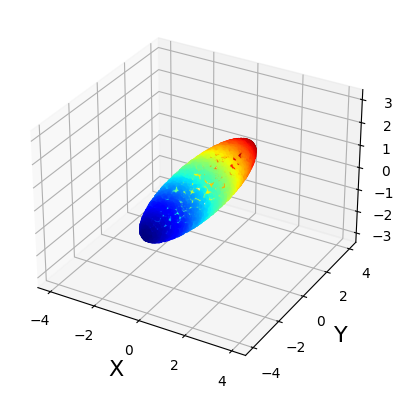

In [68]:
n_samples=4000
roi = np.linspace(0,1,10000)

u=np.random.choice(roi,n_samples)
v=np.random.choice(roi,n_samples)

theta = u * 2.0 * np.pi
phi = np.arccos(2.0 * v - 1.0)

sinTheta = np.sin(theta);
cosTheta = np.cos(theta);
sinPhi = np.sin(phi);
cosPhi = np.cos(phi);



x1 = 1 * sinPhi * cosTheta;
x2 = 4 * sinPhi * sinTheta;
x3 = 1 * cosPhi;

color_label=np.zeros((n_samples))
color_label[np.argsort(x2)]=np.arange(n_samples)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x1, x2, x3,  s=5, c=color_label,alpha=0.8,cmap=plt.cm.jet)
ax.set_xlabel("X",fontsize=16)
ax.set_ylabel("Y",fontsize=16)
ax.set_zlabel("Z",fontsize=16)

plt.axis('equal')
plt.savefig(result_dir+'ellipsoid.png')
plt.show()

X_major=np.array([x1,x2,x3]).T
X_minor=0.1*np.random.randn(n_samples,7)
X=np.hstack((X_major,X_minor))

In [69]:
# def make_swiss_roll_m(n_samples=100, *, noise=0.0, random_state=None, hole=False):

#     generator = check_random_state(random_state)

#     if not hole:
#         t = 1.5 * np.pi * (1 + 2 * generator.uniform(size=n_samples))
#         y = 10 * generator.uniform(size=n_samples)
#     else:
#         corners = np.array(
#             [[np.pi * (1.5 + i), j * 7] for i in range(3) for j in range(3)]
#         )
#         corners = np.delete(corners, 4, axis=0)
#         corner_index = generator.choice(8, n_samples)
#         parameters = generator.uniform(size=(2, n_samples)) * np.array([[np.pi], [7]])
#         t, y = corners[corner_index].T + parameters

#     x = t * np.cos(t)
#     z = t * np.sin(t)

#     X = np.vstack((x, y, z))
#     X += noise * generator.standard_normal(size=(3, n_samples))
#     X = X.T
#     t = np.squeeze(t)

#     return X, t

In [70]:
# n_samples=4000
# X_minor=0.1*np.random.randn(n_samples,7)
# # X_major, color_label = make_s_curve(n_samples, random_state=0)
# # X_major, color_label = make_swiss_roll(n_samples=n_samples, noise=0.5,hole=False)
# X_major, color_label = make_swiss_roll_m(n_samples=n_samples, noise=0,hole=True)

# X=np.hstack((X_major,X_minor))

# fig = plt.figure(figsize=(8, 6))
# ax = fig.add_subplot(111, projection="3d")
# fig.add_axes(ax)
# ax.scatter(
#     X[:, 0], X[:, 1], X[:, 2], c=color_label, s=20, alpha=0.8,cmap=plt.cm.jet
# )
# # ax.set_title("Swiss Roll in Ambient Space")
# ax.view_init(azim=-116, elev=12)
# # _ = ax.text2D(0.8, 0.05, s="n_samples=1500", transform=ax.transAxes)


# ax.set_xlabel("X",fontsize=16)
# ax.set_ylabel("Y",fontsize=16)
# ax.set_zlabel("Z",fontsize=16)

# # plt.axis('equal')
# plt.savefig(result_dir+'swiss_roll.png')
# plt.show()

In [71]:
k_nei=10
A = kneighbors_graph(X, k_nei, mode='connectivity', include_self=True)
# A=radius_neighbors_graph(X,3,include_self=True)

In [72]:
row =np.array([np.ones((k_nei,))*i for i in range(X.shape[0])]).flatten()

col= np.array([np.where(A.getrow(i).toarray()[0,:])[0] for i in range(X.shape[0])]).flatten()

w_val=np.array([np.linalg.norm(X[int(i),:]-X[int(j),:]) for i,j in zip(row,col)])

adj_val=np.ones(col.shape)

A_mat=csr_matrix((adj_val, (row, col)), shape=(X.shape[0], X.shape[0]))

W_mat=csr_matrix((w_val, (row, col)), shape=(X.shape[0], X.shape[0]))

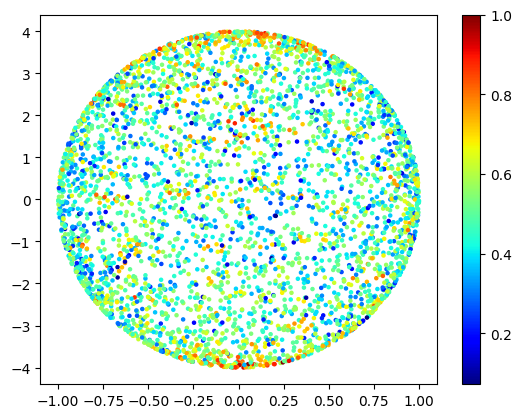

In [73]:
dc=np.mean(w_val)

cell_nei=A.indices.reshape(n_samples,k_nei).copy().copy()#np.array([np.where(A.getrow(i).toarray()[0,:])[0] for i in range(X.shape[0])]).astype(np.int32)
nei_w=[]
rho_arr=[]
for ni in cell_nei:
    dij=np.array([np.linalg.norm(X[int(ni[0]),:]-X[int(i),:]) for i in ni[1:]])
    
    rho=np.sum(np.exp(-dij**2/dc**2))
#     rho=np.exp(np.sum(-dij**2/dc**2))
    nei_w.append(np.exp(-dij**2/dc**2)/np.sum(np.exp(-dij**2/dc**2)))
#     print(dij)
#     print(np.exp(-dij**2/dc**2)/np.sum(np.exp(-dij**2/dc**2)))
    rho_arr.append(rho)
rho_arr=np.array(rho_arr)/np.amax(rho_arr)
nei_w=np.array(nei_w)
nei_w=np.hstack((np.ones((nei_w.shape[0],1)),nei_w))/2


plt.scatter(X[:,0],X[:,1],s=5,c=rho_arr,cmap=plt.cm.jet)
plt.colorbar()
plt.show()


def smooth_func(X_val,cell_nei,nei_w):
    X_sm=X_val.copy()
    for ci in range(len(X_val)):
        X_sm[ci]=np.dot(X_val[cell_nei[ci,:]],nei_w[ci,:])
    return X_sm

In [74]:
cell_nei

array([[   0, 1917, 1768, ..., 3331, 1056, 1436],
       [   1, 3392, 1396, ..., 1434, 2331,  740],
       [   2, 1304, 2308, ...,  337,  699, 3078],
       ...,
       [3997, 2038,  177, ..., 2443, 2313, 2332],
       [3998, 2743,  446, ..., 3686, 2617, 1209],
       [3999, 1047,  462, ...,  592,  360, 1087]], dtype=int32)

In [75]:
def embed_dist_compare(A,X,em_X):
    dist_ratios=[]
    for ori_inds in np.split(A.indices, A.indptr)[1:-1]:
        dist_r=[]
        self_ind=ori_inds[0]
        for nei_k in range(1,len(ori_inds)):

            dEu=np.linalg.norm(X[self_ind,:]-X[ori_inds[nei_k],:])


            em_dEu=np.linalg.norm(em_X[self_ind,:]-em_X[ori_inds[nei_k],:]) 
            dist_r.append(dEu/em_dEu)
#         print(np.std(dist_r)/np.mean(dist_r))
        dist_ratios.append(np.std(dist_r)/np.mean(dist_r))
    return np.array(dist_ratios)

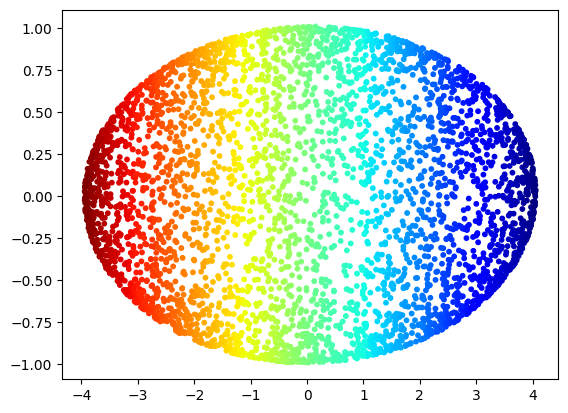

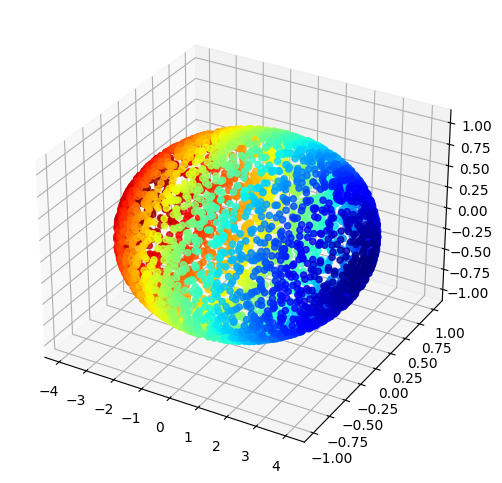

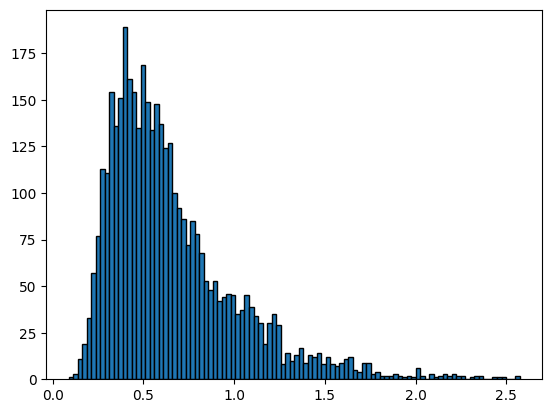

In [76]:

pca=PCA(n_components=3).fit(X)
S_pca=pca.transform(X)
plt.scatter(S_pca[:,0],S_pca[:,1],s=10,c=color_label,cmap=plt.cm.jet)
plt.show()
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d")
fig.add_axes(ax)
ax.scatter(
    S_pca[:, 0],S_pca[:, 1], S_pca[:, 2], c=color_label, s=20, alpha=0.8,cmap=plt.cm.jet
)
plt.show()

ratio_compare=embed_dist_compare(A,X,S_pca[:,:2])
plt.hist(ratio_compare,bins=100,edgecolor='black')
plt.show()

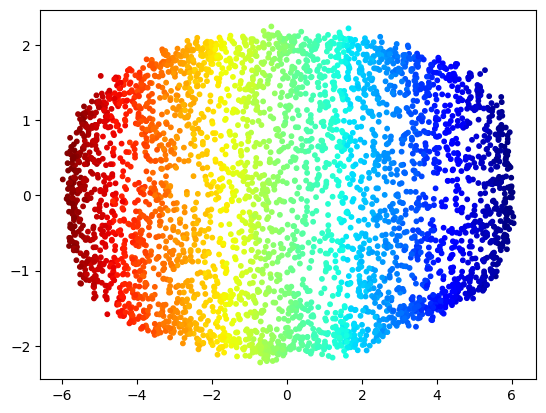

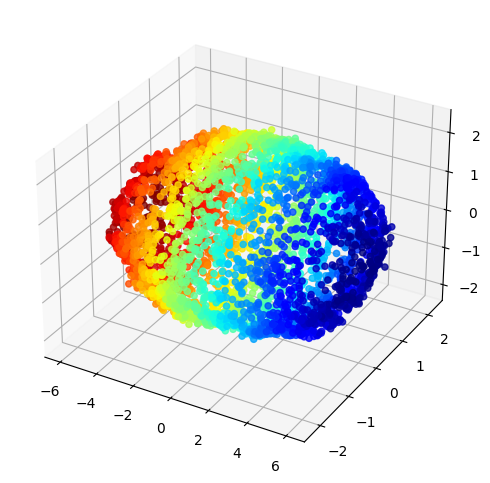

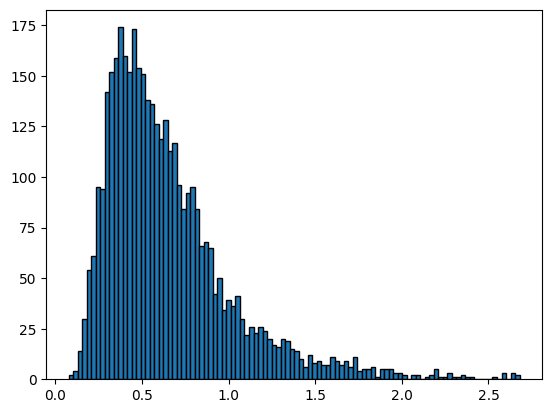

In [77]:
isomap = manifold.Isomap(n_neighbors=10,n_components=3, p=2)#radius=5, 
S_isomap = isomap.fit_transform(X)
plt.scatter(S_isomap[:,0],S_isomap[:,1],s=10,c=color_label,cmap=plt.cm.jet)
plt.show()

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d")
fig.add_axes(ax)
ax.scatter(
    S_isomap[:, 0],S_isomap[:, 1], S_isomap[:, 2], c=color_label, s=20, alpha=0.8,cmap=plt.cm.jet
)
plt.show()

ratio_compare=embed_dist_compare(A,X,S_isomap[:,:2])
plt.hist(ratio_compare,bins=100,edgecolor='black')
plt.show()

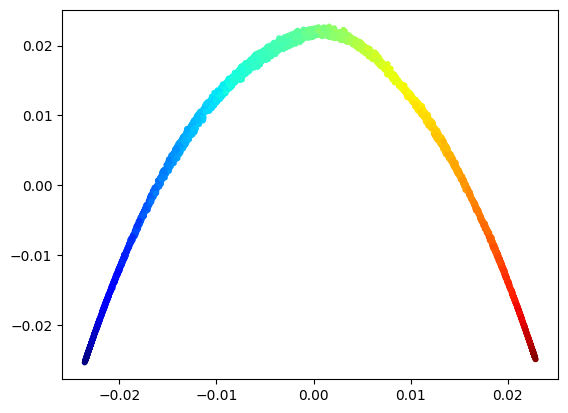

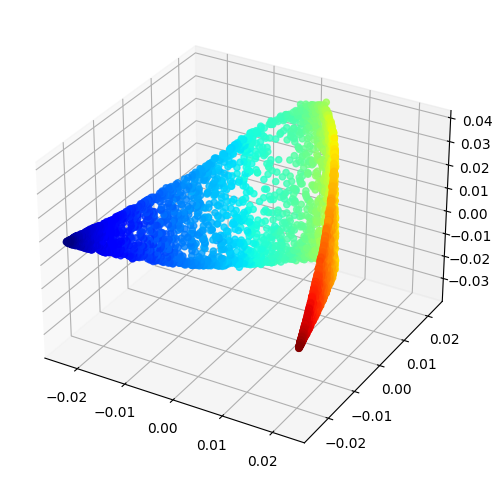

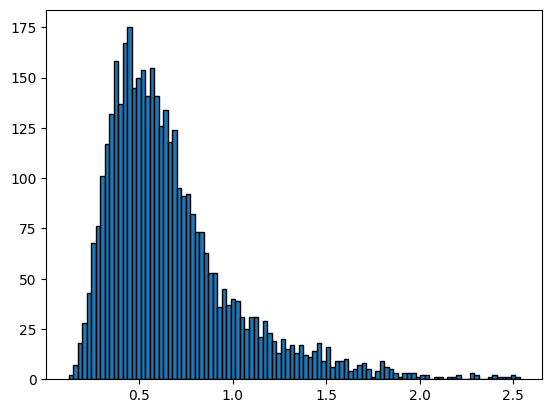

In [78]:
#ltsa,standard,hessian,modified
lle = manifold.LocallyLinearEmbedding(method="modified",n_neighbors=10, n_components=3)
S_lle= lle.fit_transform(X)

plt.scatter(S_lle[:,0],S_lle[:,1],s=10,c=color_label,cmap=plt.cm.jet)
plt.show()

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d")
fig.add_axes(ax)
ax.scatter(
    S_lle[:, 0],S_lle[:, 1], S_lle[:, 2], c=color_label, s=20, alpha=0.8,cmap=plt.cm.jet
)
plt.show()

ratio_compare=embed_dist_compare(A,X,S_lle)
plt.hist(ratio_compare,bins=100,edgecolor='black')
plt.show()

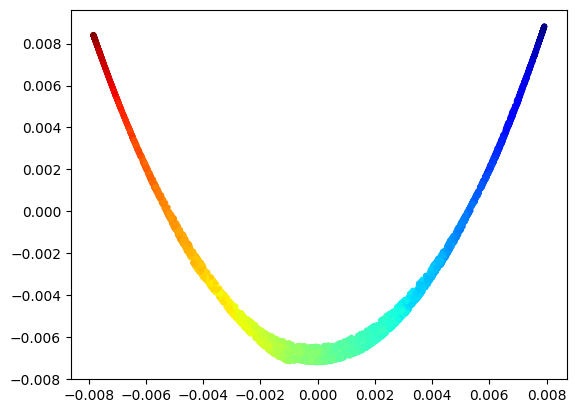

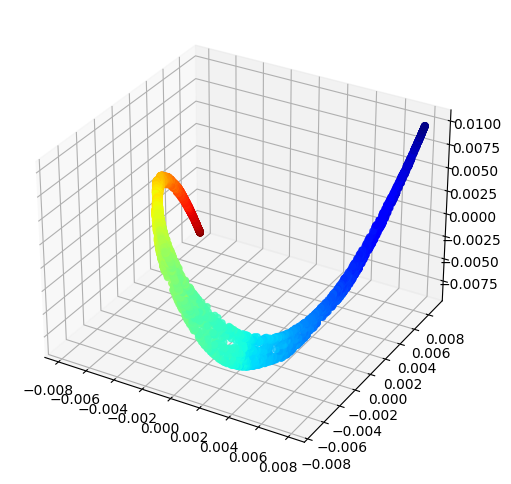

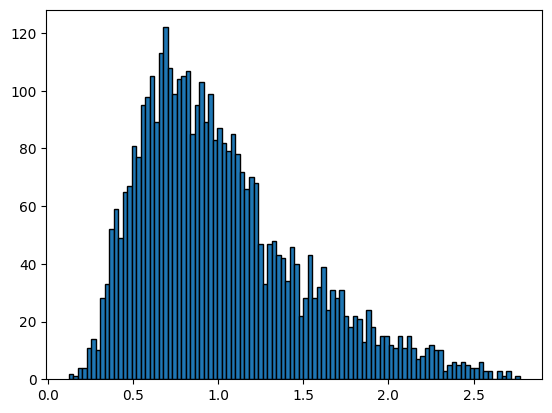

In [79]:
se = manifold.SpectralEmbedding(n_components=3, n_neighbors=10)
S_se= se.fit_transform(X)

plt.scatter(S_se[:,0],S_se[:,1],s=10,c=color_label,cmap=plt.cm.jet)
plt.show()

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d")
fig.add_axes(ax)
ax.scatter(
    S_se[:, 0],S_se[:, 1], S_se[:, 2], c=color_label, s=20, alpha=0.8,cmap=plt.cm.jet
)
plt.show()

ratio_compare=embed_dist_compare(A,X,S_se)
plt.hist(ratio_compare,bins=100,edgecolor='black')
plt.show()

/Users/fz2gz/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/fz2gz/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


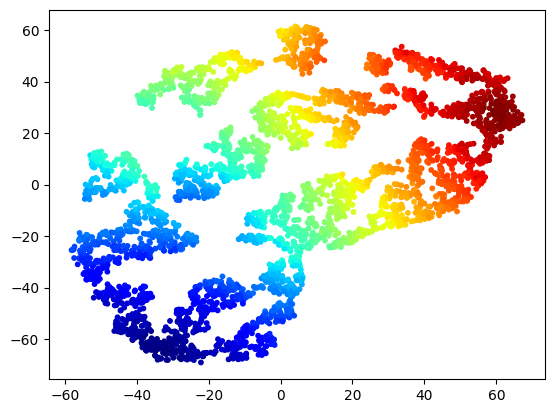

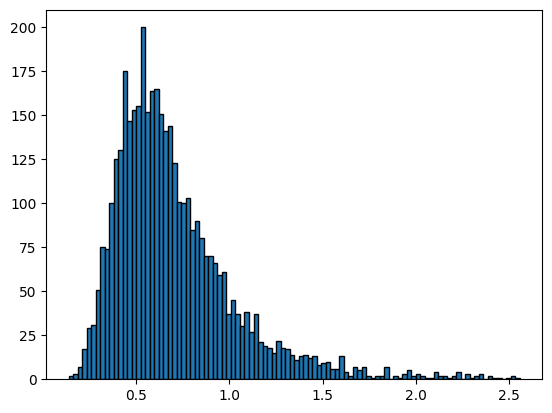

In [80]:
tsne = manifold.TSNE(n_components=2, random_state=0)
S_tsne = tsne.fit_transform(X)

plt.scatter(S_tsne[:,0],S_tsne[:,1],s=10,c=color_label,cmap=plt.cm.jet)
plt.show()

# fig = plt.figure(figsize=(8, 6))
# ax = fig.add_subplot(111, projection="3d")
# fig.add_axes(ax)
# ax.scatter(
#     S_tsne[:, 0],S_tsne[:, 1], S_tsne[:, 2], c=color_label, s=20, alpha=0.8,cmap=plt.cm.jet
# )
# plt.show()

ratio_compare=embed_dist_compare(A,X,S_tsne)
plt.hist(ratio_compare,bins=100,edgecolor='black')
plt.show()

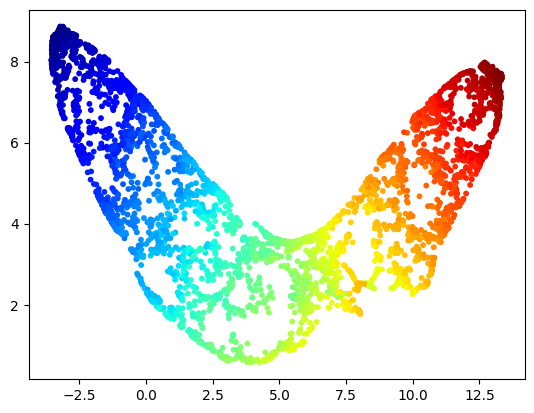

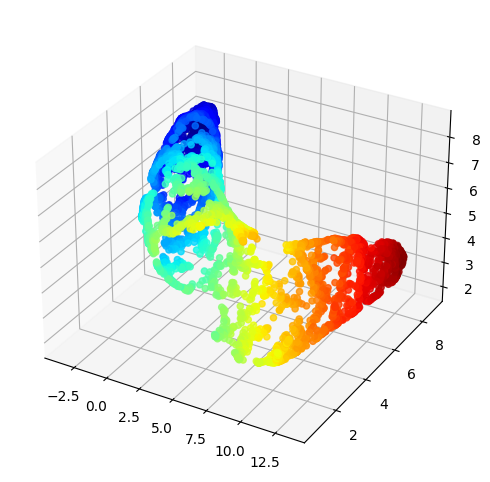

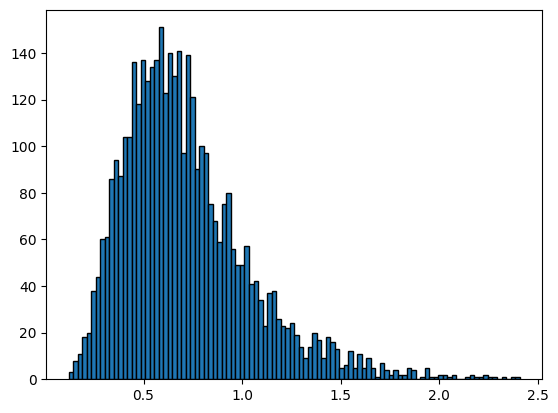

In [81]:

um = umap.UMAP(n_neighbors=10,n_components=3)
S_um = um.fit_transform(X)

plt.scatter(S_um[:,0],S_um[:,1],s=10,c=color_label,cmap=plt.cm.jet)
plt.show()

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d")
fig.add_axes(ax)
ax.scatter(
    S_um[:, 0],S_um[:, 1], S_um[:, 2], c=color_label, s=20, alpha=0.8,cmap=plt.cm.jet
)
plt.show()

ratio_compare=embed_dist_compare(A,X,S_um)
plt.hist(ratio_compare,bins=100,edgecolor='black')
plt.show()

In [82]:
epochs = 200
nsamples = 5
learning_rate = 1e-3
seed = 1987
n_workers = 0
K =3
#     checkpoint_path = args.checkpoint
#     checkpoints_path = args.checkpoints
#     dataset_path = args.dataset

if seed is not None:
    reset_seeds(seed)

A=A.astype(np.float32)
X=X.astype(np.float32)
z=color_label

n = A.shape[0]
train_nodes, val_nodes = train_test_split(n, train_ratio=1)
A_train = A[train_nodes, :][:, train_nodes]
X_train = X[train_nodes]
z_train = z[train_nodes]
A_val = A[val_nodes, :][:, val_nodes]
X_val = X[val_nodes]
z_val = z[val_nodes]

train_data = AttributedGraph(A_train, X_train, z_train, K)
val_data = AttributedGraph(A_val, X_val, z_val, K)

L = 3
encoder = Encoder(X.shape[1], L)

In [83]:
optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)

iterations = epochs #// n_workers
dataset = GraphDataset(train_data, nsamples, iterations)
loader = DataLoader(
    dataset,
    batch_size=1,
    num_workers=n_workers,
    worker_init_fn=reset_seeds,
    collate_fn=lambda args: args,
)

In [84]:
for batch_idx, data in enumerate(loader):
    encoder.train()
    optimizer.zero_grad()

    loss = encoder.compute_loss(data[0][0],data[0][1],data[0][2],data[0][3],data[0][4],data[0][5])
    if batch_idx% 10 == 0:
        print(batch_idx,loss)
    loss.backward()
    optimizer.step()

0 tensor(1.4890e+09, grad_fn=<DivBackward0>)
10 tensor(6.9765e+08, grad_fn=<DivBackward0>)
20 tensor(6.4421e+08, grad_fn=<DivBackward0>)
30 tensor(6.4159e+08, grad_fn=<DivBackward0>)
40 tensor(6.3554e+08, grad_fn=<DivBackward0>)
50 tensor(6.2772e+08, grad_fn=<DivBackward0>)
60 tensor(6.2660e+08, grad_fn=<DivBackward0>)
70 tensor(6.2808e+08, grad_fn=<DivBackward0>)
80 tensor(6.2648e+08, grad_fn=<DivBackward0>)
90 tensor(6.2110e+08, grad_fn=<DivBackward0>)
100 tensor(6.1944e+08, grad_fn=<DivBackward0>)
110 tensor(6.1690e+08, grad_fn=<DivBackward0>)
120 tensor(6.1377e+08, grad_fn=<DivBackward0>)
130 tensor(6.1773e+08, grad_fn=<DivBackward0>)
140 tensor(6.1512e+08, grad_fn=<DivBackward0>)
150 tensor(6.1153e+08, grad_fn=<DivBackward0>)
160 tensor(6.0724e+08, grad_fn=<DivBackward0>)
170 tensor(6.1488e+08, grad_fn=<DivBackward0>)
180 tensor(6.1414e+08, grad_fn=<DivBackward0>)
190 tensor(6.1344e+08, grad_fn=<DivBackward0>)


In [85]:
# optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)

# def step(engine, args):
#     optimizer.zero_grad()

#     loss = encoder.compute_loss(*args[0])
#     loss.backward()

#     optimizer.step()

#     return loss.item()

# trainer = Engine(step)


# @trainer.on(Events.ITERATION_STARTED)
# def enable_train_mode(engine):
#     encoder.train()

# @trainer.on(Events.ITERATION_COMPLETED)
# def log_loss(engine):
#     if engine.state.iteration % 10 == 0:
#         print(f"Epoch {engine.state.iteration:2d} - Loss {engine.state.output:.3f}")

# @trainer.on(Events.ITERATION_COMPLETED)
# def run_validation(engine):
#     if engine.state.iteration % 50 != 1:
#         return

#     # Skip if there is no validation set
#     if val_data.A.shape[0] == 0:
#         return

#     encoder.eval()
#     loss = encoder.compute_loss(val_data, nsamples)
#     print(f"Validation loss {loss:.3f}")


# iterations = epochs // n_workers
# dataset = GraphDataset(train_data, nsamples, iterations)
# loader = DataLoader(
#     dataset,
#     batch_size=1,
#     num_workers=n_workers,
#     worker_init_fn=reset_seeds,
#     collate_fn=lambda args: args,
# )
# epochs = 1
# trainer.run(loader, epochs)

In [86]:
z=train_data.z
mu, sigma = encoder(train_data.X)
mu_learned = mu.detach().numpy()
sigma_learned = np.sqrt(sigma.detach().numpy())#sigma.detach().numpy()##The learned sigma is variance

In [87]:
sort_idx = z.argsort()

match_idx=sort_idx[np.searchsorted(z,color_label,sorter = sort_idx)]
print(match_idx)

[2635 1778 2643 ...  621 1008 3135]


In [88]:
X_mu=mu_learned[match_idx]
X_sigma=sigma_learned[match_idx]
X_label=z[match_idx]

In [89]:
latent_z=[]
for i in range(X_mu.shape[1]):
    latent_z.append(X_mu[:,i])
    latent_z.append(X_sigma[:,i])
latent_z=np.array(latent_z).T
latent_z.shape

(4000, 6)

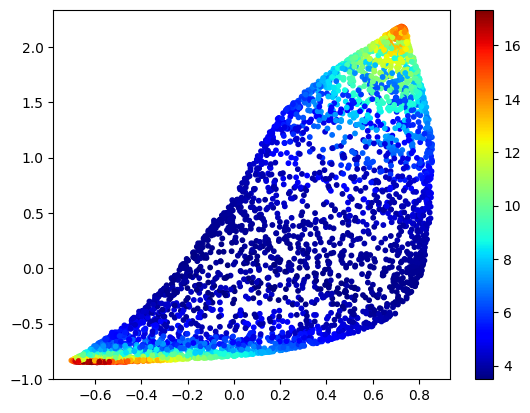

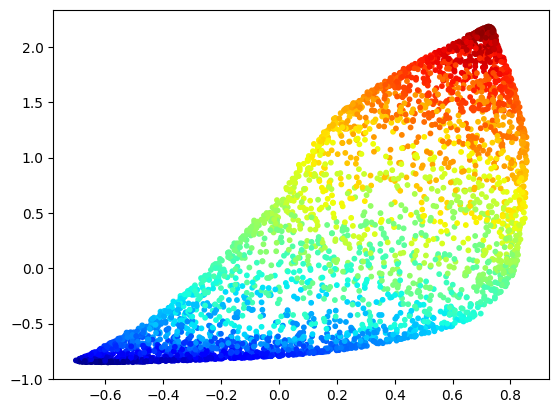

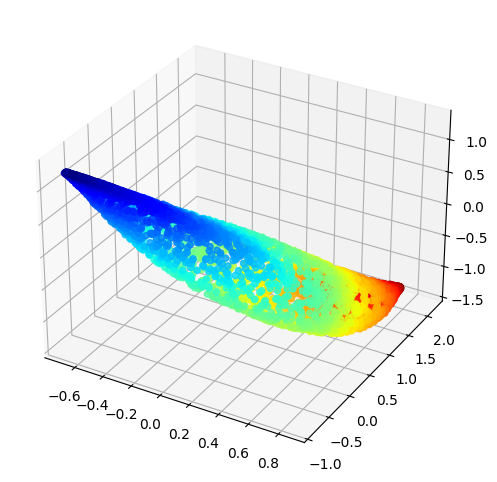

In [90]:
plt.scatter(X_mu[:,0],X_mu[:,1],s=10,c=np.sum(1/X_sigma**2,axis=1),cmap=plt.cm.jet)
plt.colorbar()
plt.show()

plt.scatter(X_mu[:,0],X_mu[:,1],s=10,c=X_label,cmap=plt.cm.jet)
plt.show()


fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d")
fig.add_axes(ax)
ax.scatter(
    X_mu[:, 0],X_mu[:, 1], X_mu[:, 2], c=X_label, s=20, alpha=0.8,cmap=plt.cm.jet
)
plt.show()

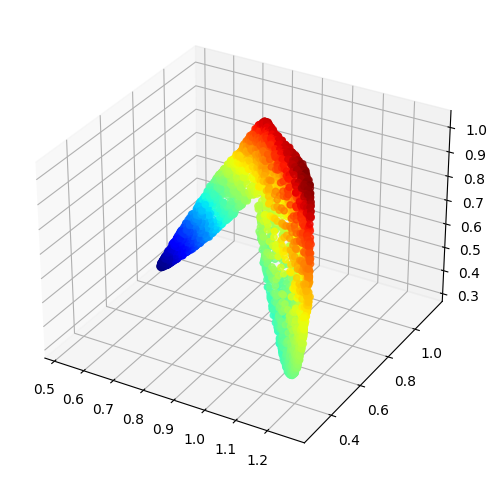

In [91]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d")
fig.add_axes(ax)
ax.scatter(
    X_sigma[:, 0],X_sigma[:, 1], X_sigma[:, 2], c=np.sum(X_sigma**2,axis=1), s=20, alpha=0.8,cmap=plt.cm.jet
)
plt.show()

In [92]:
Fisher_g=np.zeros((X.shape[0],L*2,L*2))
for i in range(X.shape[0]):
    for j in range(L):
        Fisher_g[i,2*j,2*j]=1/(X_sigma[i,j]**2)
        Fisher_g[i,2*j+1,2*j+1]=2/(X_sigma[i,j]**2)

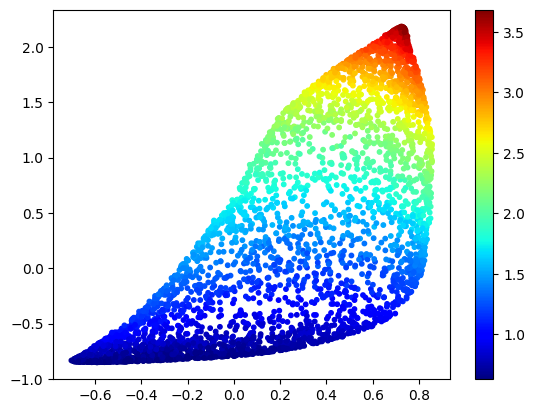

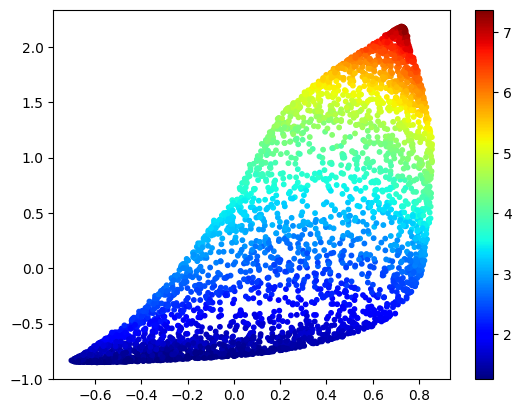

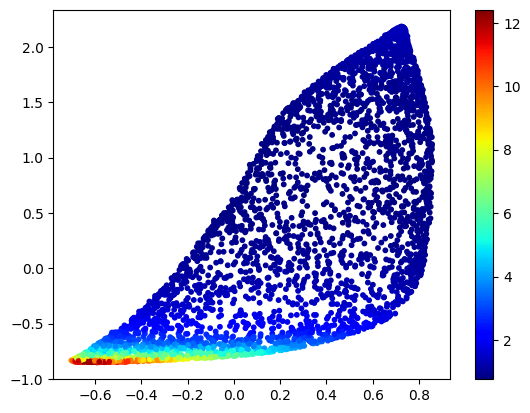

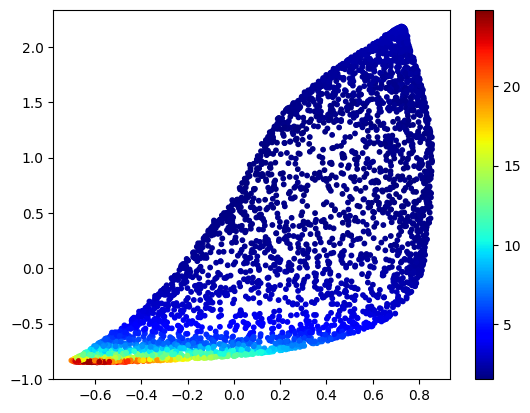

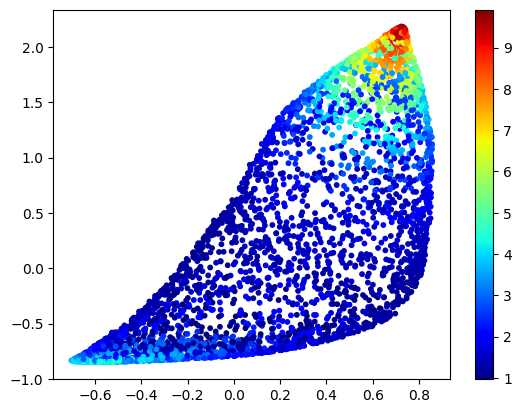

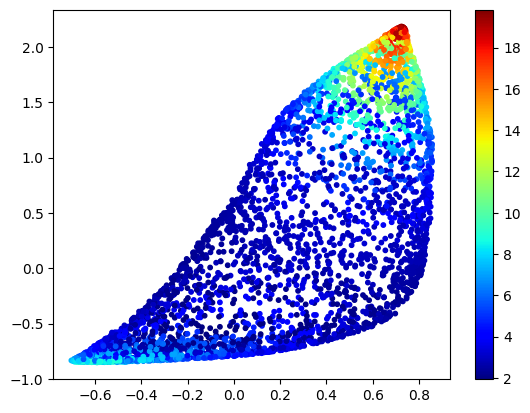

In [93]:
for j in range(L*2):

    plt.scatter(X_mu[:,0],X_mu[:,1],s=10,c=Fisher_g[:,j,j],cmap=plt.cm.jet)
    plt.colorbar()
    plt.show()

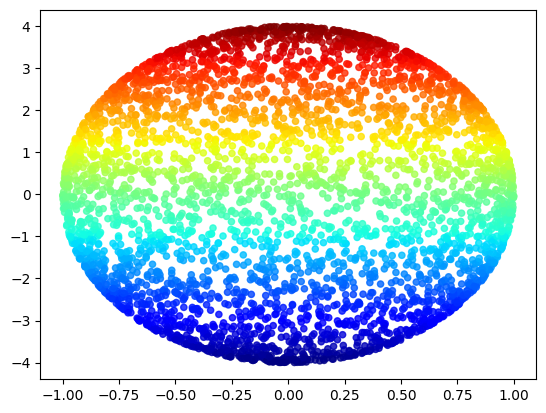

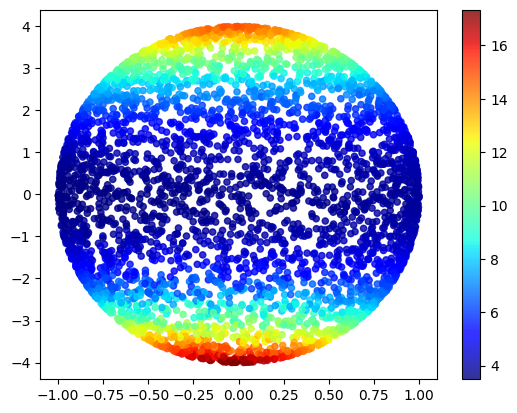

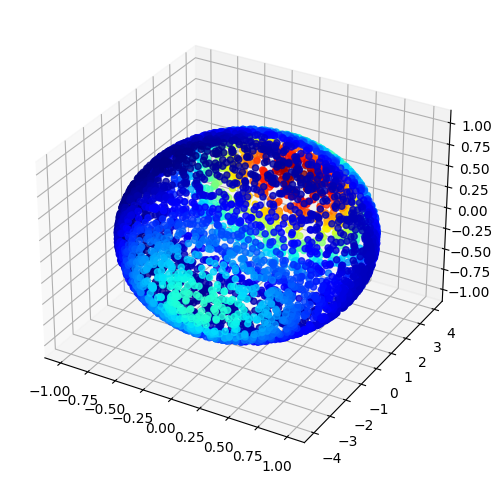

In [94]:
plt.scatter(X[:, 0],X[:, 1], c=color_label, s=20, alpha=0.8,cmap=plt.cm.jet)
plt.show()


plt.scatter(X[:, 0],X[:, 1], c=np.sum(1/X_sigma**2,axis=1), s=20, alpha=0.8,cmap=plt.cm.jet)
plt.colorbar()
plt.show()

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d")
fig.add_axes(ax)
ax.scatter(
    X[:, 0],X[:, 1], X[:, 2], c=Fisher_g[:,4,4], s=20, alpha=0.8,cmap=plt.cm.jet
)
plt.show()

In [95]:
def Fisher_dist(mu1,sigma1,mu2,sigma2):
    dim=len(mu1)
    dF2=0
    for i in range(dim):
        a=np.sqrt(((mu1[i]-mu2[i])/np.sqrt(2))**2+(sigma1[i]+sigma2[i])**2)+\
          np.sqrt(((mu1[i]-mu2[i])/np.sqrt(2))**2+(sigma1[i]-sigma2[i])**2)
        b=np.sqrt(((mu1[i]-mu2[i])/np.sqrt(2))**2+(sigma1[i]+sigma2[i])**2)-\
          np.sqrt(((mu1[i]-mu2[i])/np.sqrt(2))**2+(sigma1[i]-sigma2[i])**2)
        
        dF2+=2*(np.log(a/b))**2
    dF=np.sqrt(dF2)
    return dF

In [96]:
def KL_dist(mu1,sigma1,mu2,sigma2):
    dim=len(mu1)
    dmu=mu1-mu2
    KL_dist=0
    for i in range(dim):
        #the after KL_12+KL_21 the log(det(sigma1)/det(sigma2))+log(det(sigma2)/det(sigma1))=0
        # so do not calculate this term
        KL_12=1/2*(-1+sigma1[i]**2/sigma2[i]**2+dmu[i]**2/sigma2[i]**2)
        KL_21=1/2*(-1+sigma2[i]**2/sigma1[i]**2+dmu[i]**2/sigma1[i]**2)
        KL_sym=KL_12+KL_21
        KL_dist+=KL_sym
    return KL_dist

In [97]:
# A = kneighbors_graph(X, k_nei, mode='connectivity', include_self=True)
# np.split(A.indices, A.indptr)[1:-1][-10:]

In [98]:
cell_nei[-10:,:]

array([[3990, 3195, 2159, 2860, 3258, 2730, 3344, 2571, 1968, 3125],
       [3991, 3504, 3789, 3904,  834,  865, 2973,  631, 2100, 2327],
       [3992, 3823, 2349, 2967, 1196, 2475, 3980, 1487,  730, 3534],
       [3993, 2149, 1935, 1232, 2417, 2895, 1467, 3830, 2641, 2484],
       [3994, 1450, 1751, 3654, 2659, 2412, 3024, 3805, 3833, 2570],
       [3995, 2939, 2112, 2443, 3726, 1494, 2616,  177, 3228, 3096],
       [3996,  647, 1774, 2170, 2274, 2150, 2231, 1105,  801, 1160],
       [3997, 2038,  177, 3228, 1494, 2409, 2269, 2443, 2313, 2332],
       [3998, 2743,  446,  392, 3001,  280,  923, 3686, 2617, 1209],
       [3999, 1047,  462, 3453,  638, 2293,  352,  592,  360, 1087]],
      dtype=int32)

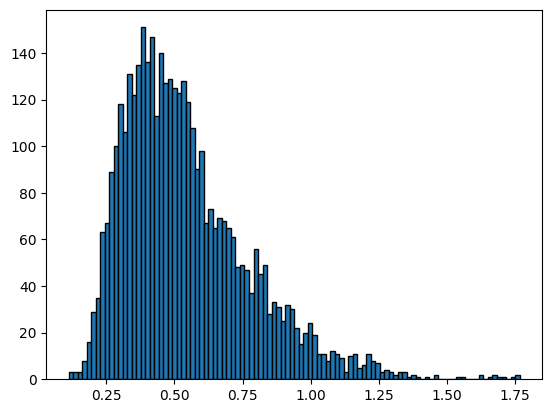

In [99]:
#-------------calcualte distance pair--------------
dist_ratios=[]
for inds in cell_nei:

    dist_r=[]
    self_ind=inds[0]
    for nei_k in range(1,len(inds)):
        
        dEu=np.linalg.norm(X[self_ind,:]-X[inds[nei_k],:])
        dFi=Fisher_dist(X_mu[self_ind,:],X_sigma[self_ind,:],\
                        X_mu[inds[nei_k],:],X_sigma[inds[nei_k],:])

        gau_dEu=np.linalg.norm(X_mu[self_ind,:]-X_mu[inds[nei_k],:])
        
        dKL=KL_dist(X_mu[self_ind,:],X_sigma[self_ind,:],\
                        X_mu[inds[nei_k],:],X_sigma[inds[nei_k],:])
        
        dist_r.append(dEu/dFi)

        
        
#     print(np.std(dist_r)/np.mean(dist_r))
    
    dist_ratios.append(np.std(dist_r)/np.mean(dist_r))

plt.hist(np.array(dist_ratios),bins=100,edgecolor='black')
plt.show()

In [100]:
def wasserstein_distance(mu1,sigma1,mu2,sigma2):
    dim=len(mu1)
    dmu=mu1-mu2
    W_dist2=0
    for i in range(dim):
        W_dist2+=dmu[i]**2+sigma1[i]**2+sigma2[i]**2-2*np.sqrt(sigma2[i]*sigma1[i]**2*sigma2[i])
    W_dist=np.sqrt(W_dist2)
    return W_dist

In [101]:
cRc_arr=[]
for inds in cell_nei:
    print(inds)

    self_ind=inds[0]
    cRc=0
    for nei_k in range(1,len(inds)):
        
        dEu=np.linalg.norm(X[self_ind,:]-X[inds[nei_k],:])
        dFi=Fisher_dist(X_mu[self_ind,:],X_sigma[self_ind,:],\
                        X_mu[inds[nei_k],:],X_sigma[inds[nei_k],:])
        dWa=wasserstein_distance(X_mu[self_ind,:],X_sigma[self_ind,:],\
                        X_mu[inds[nei_k],:],X_sigma[inds[nei_k],:])
        
        cRc+=(1-dWa/dEu)
    
    cRc_arr.append(cRc/len(inds))
#     cRc_arr.append(cRc)
cRc_arr=np.array(cRc_arr)

[   0 1917 1768 2725 3519  624 2072 3331 1056 1436]
[   1 3392 1396  773   55 3606  380 1434 2331  740]
[   2 1304 2308  580  741  978 3621  337  699 3078]
[   3 1845 1265 2387 3547 1704 1685 2591 3130  458]
[   4 1575  232  169 2829  833 2627  896 2898  643]
[   5  863 2104 2504  996 1188 3638 1256 1345 2611]
[   6  206  158 1064 2064  305 1174 1724 1413 2006]
[   7 1181 3222 1236   30 2054 1919  492 2568 3143]
[   8 2703 2745  914 1908 1922 3929  744 3777 1830]
[   9 3394 2981 2236 1614 1222 1124  617 1633  105]
[  10 3926 3685 3123 3081 2794 3629  574 1484 2753]
[  11  841 2004 3670  559  315 2244 1014 2564 3035]
[  12 2738 1928 3272 2030 2877  862 3811 2829 2290]
[  13 2560 3287  167 2590 2564 3873 1786 1518 2498]
[  14 2541 1811  403 2745 1737 3777  801 1956 2876]
[  15 2330 1875 3319  657 2186 3660 2916 1634 1068]
[  16  682  980  867 2205 1716  472 2680 1215 3841]
[  17 2742  130 2120 2088  270 1883 1321 2382 2115]
[  18 1205 3355 2518  951 3806 2705 1027  734 1939]
[  19 2450 1

In [102]:
cRc_smooth=smooth_func(cRc_arr,cell_nei,nei_w)

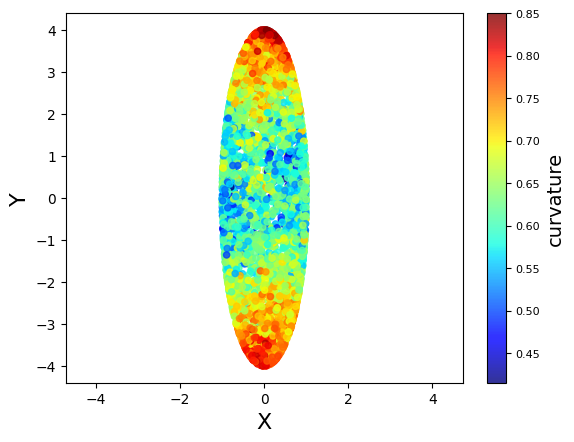

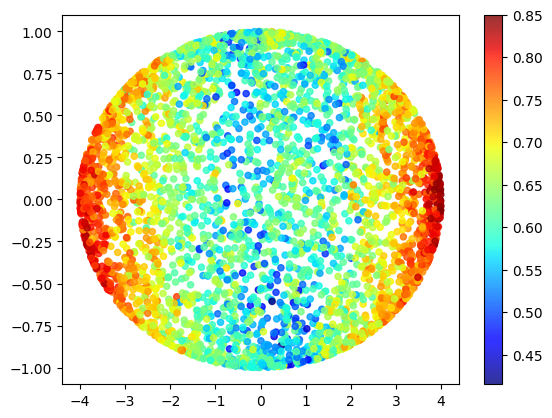

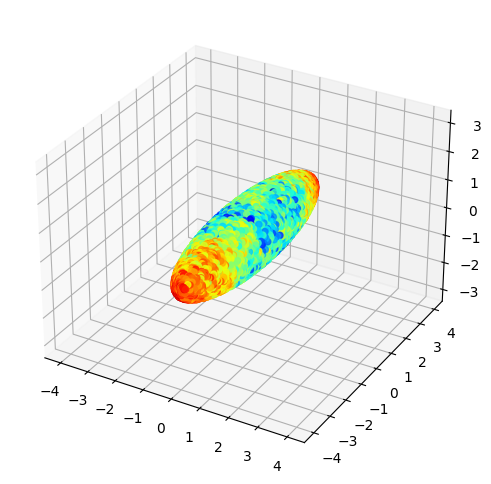

In [103]:
plt.scatter(X[:, 0],X[:, 1], c=cRc_arr, s=20, alpha=0.8,cmap=plt.cm.jet)
clb=plt.colorbar()
clb.ax.tick_params(labelsize=8)
# clb.ax.set_title('curvature',fontsize=16)

clb.ax.set_ylabel('curvature',fontsize=14)
plt.xlabel('X',fontsize=16)
plt.ylabel('Y',fontsize=16)
plt.axis('equal')
plt.savefig(result_dir+'swissroll_cRc.png')
plt.show()

plt.scatter(X[:, 1],X[:, 2], c=cRc_arr, s=20, alpha=0.8,cmap=plt.cm.jet)
plt.colorbar()
plt.show()

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d")
fig.add_axes(ax)
ax.scatter(
    X[:, 0],X[:, 1], X[:, 2], c=cRc_arr, s=20, alpha=0.8,cmap=plt.cm.jet
)
plt.axis('equal')
plt.savefig(result_dir+'swissroll_3D_cRc.png')
plt.show()

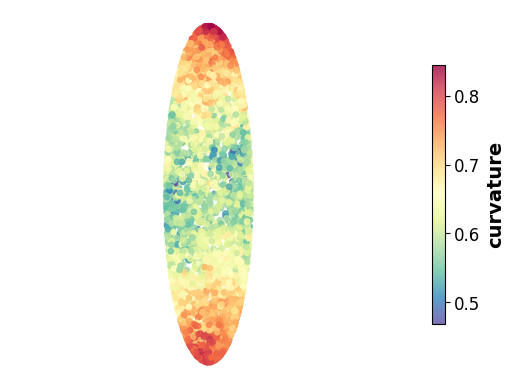

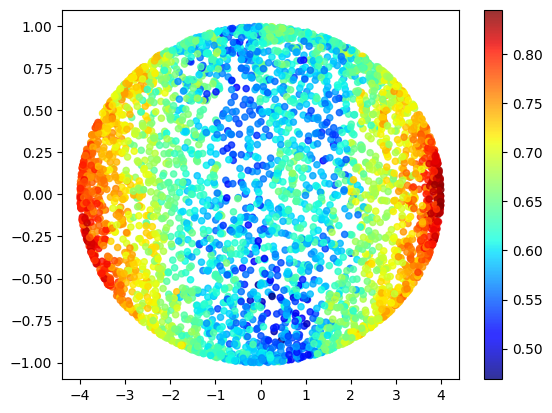

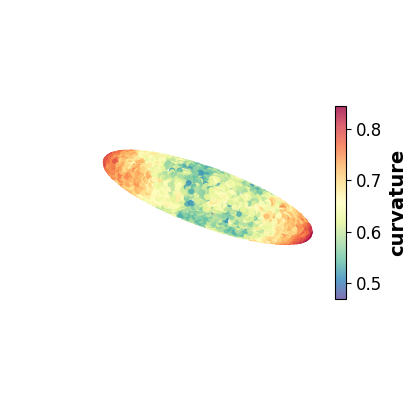

In [129]:
plt.scatter(X[:, 0],X[:, 1], c=cRc_smooth, s=15, alpha=0.8,cmap = plt.colormaps['Spectral_r'])
clb=plt.colorbar(shrink=0.7)
clb.ax.tick_params(labelsize=12)
# clb.ax.set_title('curvature',fontsize=16)

clb.ax.set_ylabel('curvature',fontsize=14,fontweight='bold')
plt.xlabel('X',fontsize=16)
plt.ylabel('Y',fontsize=16)
plt.axis('equal')
plt.axis('off')
plt.savefig(result_dir+'ellipsoid.png',dpi=300)
plt.show()

plt.scatter(X[:, 1],X[:, 2], c=cRc_smooth, s=20, alpha=0.8,cmap=plt.cm.jet)
plt.colorbar()
plt.show()

fig = plt.figure(figsize=(7.5, 5))
ax = fig.add_subplot(111, projection="3d")
# fig.add_axes(ax)
p=ax.scatter(
    X[:, 0],X[:, 1], X[:, 2], c=cRc_smooth, s=10, alpha=0.8,cmap=plt.colormaps['Spectral_r']
)

ax.view_init(elev=90, azim=40, roll=25)
ax.set_axis_off()
plt.axis('equal')
cax = fig.add_axes([ax.get_position().x1-0.08,ax.get_position().y0+\
                    ax.get_position().height/4,0.015,ax.get_position().height/2])

clb=fig.colorbar(p,shrink=0.5,cax=cax)
clb.ax.tick_params(labelsize=12)

clb.ax.set_ylabel('curvature',fontsize=14,fontweight='bold')

# plt.savefig(result_dir+'swissroll_3D_cRc.png')
# fig.colorbar(p,ax=ax, shrink=0.5)
plt.savefig(result_dir+'ellipsoid_3D_cRc.png')

plt.show()